<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [12]:
import yaml
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from utils import *
from indicators import *
from dataset import Dataset
from forecaster import Forecaster
from solver import Solver
from os.path import join, isfile
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
%matplotlib inline

# torch.manual_seed(seed=42)

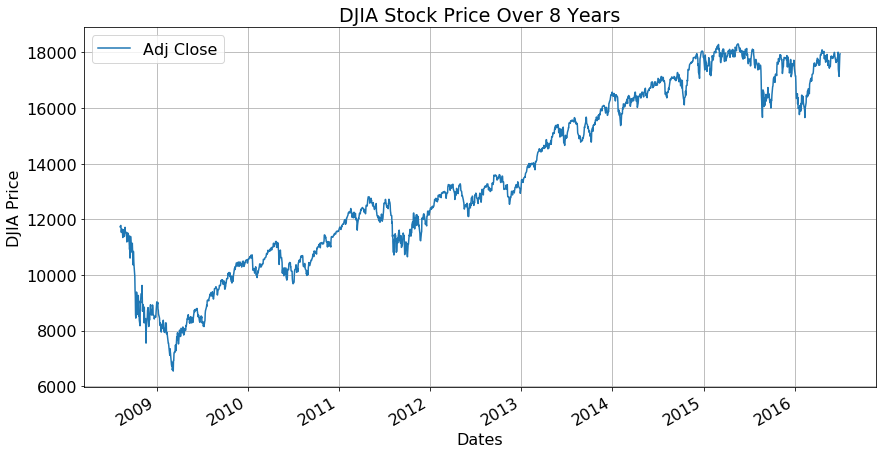

In [2]:
# Open the data file
filepath = 'data/djia.csv'

# Reads in data and checks to see none of the data is null
df_prices = pd.read_csv(filepath)
assert (df_prices.isnull().sum().sum() == 0)

# Processes file so that data is indexed by date
df_prices = df_prices.sort_values(by='Date')
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.set_index('Date', inplace=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0, 0, 1, 1])
df_prices.plot(y='Adj Close', ax=ax)
ax.set_xlabel('Dates')
ax.set_ylabel('DJIA Price')
ax.set_title('DJIA Stock Price Over 8 Years')
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

In [ ]:
####################
# Pre Process Headlines
####################

# Open the data file
filepath = 'data/djia_headlines.csv'
assert (isfile(filepath))

# Reads in data and checks to see none of the data is null
df_news = pd.read_csv(full_path)

# Processes file so that data is indexed by date
df_news = df_news.sort_values(by='Date')
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_news.set_index('Date', inplace=True)

# Cleanup
# Uppercase words help with VADER so do not do this
# df = df.apply(lambda x: x.astype(str).str.lower())
df_news = df_news.apply(lambda x: x.astype(str))

df_news.drop(['Label'], inplace=True, axis=1)
# Removes b and "
df_news = df_news.applymap(lambda x: x.lstrip('b" ').rstrip('"'))
# Removes '
df_news = df_news.applymap(lambda x: x.lstrip("b'").rstrip("'"))
to_replace = {
    '\\r\\n': ' ',
    '\\n': ' ',
    '\\r': ' ',
    '\\t': ' ',
    '\\s': ' ',
    "\\\\\\'": "'",
    "\\'": "'"
}

df_news = df_news.replace(to_replace, regex=True)
df_news.head(3)

In [ ]:
batch_size = 14
seq_length = 10
predict_ahead = 2

USE_HEADLINES = True

technical_indicators = [
    sma,  # Simple Moving Average
    wma,  # Weighted Moving Average
    mom,  # Exponential Moving Average
    macd,  # Moving Average Convergence Divergence
    rsi,  # Relative Strength Indicator
    stoch,  # Stochastic %K and %D
    willr,  # Larry Williams %R
    adosc,  # Accumulation / Distribution Oscillator
#     arima_sma,  # ARIMA on a SMA
#     arima_wma,  # ARIMA on a WMA 
#     arima_ema,  # ARIMA on an EMA
]

prices = df_prices.filter(['High', 'Low', 'Volume', 'Adj Close'], axis=1)

names = {
    'High': 'high',
    'Low': 'low',
    'Volume': 'volume',
    'Adj Close': 'close'
}

prices.rename(columns=names, inplace=True)

# Load parameter file
with open('params/djia.yaml') as file:
    params = yaml.full_load(file)

# Prepare signals dictionary layout for uploading features
signals = resetSignals(technical_indicators, params)

if USE_HEADLINES:
    headlines = df_news.filter(
        ['Date', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5'], axis=1)
else:
    headlines = None

features, labels, rowsbool = cleanData(prices, signals, predict=predict_ahead,
                                       headlines=headlines, name='djia',
                                       verbose=False)



# Prepare data for nn training
n_features = features.shape[1]

# Want to perform this on full data set before splitting
# otherwise some numbers might be larger in validation set
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler = scaler.fit(features)
scaled = scaler.transform(features)

x_all, y_all = create_sequences(scaled, labels, seq_length=seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    test_size=0.25,
    # random_state=seed)
    shuffle=False)

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_test, y_test)
}

dataloaders = {
    'train': DataLoader(data_sets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data_sets['val'], batch_size=1, shuffle=False)
}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

baseline = np.ones_like(y_test)
accuracy = accuracy_score(y_test, baseline)
print(f'Average Baseline Accuracy: {round(accuracy, 4) * 100}%')

In [ ]:
model = Forecaster(n_features=n_features, n_hidden=32, n_layers=2, dropout=0.5)
# model = Forecaster(n_features=n_features, n_hidden=8, n_layers=1, dropout=0)
solver = Solver(model, num_epochs=10, verbose=True, plot=True)
model = solver.train(dataloaders, dataset_sizes)

In [ ]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

COMPARE_W_SVM = True
if COMPARE_W_SVM:
    svm_pred = np.load('data/svm_prob_indicators_only.npy')[3:,0]
    assert y_test.flatten().shape[0] == svm_pred.shape[0]

# Model and no skill guess (always trending up)
y_test, y_pred = solver.eval(model, dataloaders['val'])
ns_pred = np.ones_like(y_pred)

fig = plt.figure(figsize=(14, 6))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_pred)
ml_fpr, ml_tpr, _ = roc_curve(y_test, y_pred)

plt.subplot(1, 2, 1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(ml_fpr, ml_tpr, marker='.', label='LSTM Model')

if COMPARE_W_SVM:
    svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pred)
    plt.plot(svm_fpr, svm_tpr, linestyle='-.', label='SVM')
    
plt.grid()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ml_precision, ml_recall, _ = precision_recall_curve(y_test, y_pred)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(ml_recall, ml_precision, marker='.', label='LSTM Model')

if COMPARE_W_SVM:
    svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_pred)
    plt.plot(svm_recall, svm_precision, linestyle='-.', label='SVM')

plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.savefig('imgs/ml_models_comparison.png')
plt.show()

# Calculate scores
ns_roc_auc = roc_auc_score(y_test, ns_pred)
ml_roc_auc = roc_auc_score(y_test, y_pred)
ml_pr_auc = auc(ml_recall, ml_precision)

ml_classifications = classify(y_pred, threshold=0.5)
ns_classifications = classify(ns_pred, threshold=0.5)

ns_accuracy = accuracy_score(y_test, ns_classifications)
ns_precision = precision_score(y_test, ns_classifications)
ns_recall = recall_score(y_test, ns_classifications)

ml_accuracy = accuracy_score(y_test, ml_classifications)
ml_precision = precision_score(y_test, ml_classifications)
ml_recall = recall_score(y_test, ml_classifications)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_roc_auc))
print('No Skill: Precision=%.3f' % ns_precision)
print('No Skill: Recall=%.3f' % ns_recall)
print('No Skill: Accuracy=%.3f' % ns_accuracy)
print('-------------------------')
print('LSTM Model: ROC AUC=%.3f' % (ml_roc_auc))
print('LSTM Model: PR AUC=%.3f' % (ml_pr_auc))
print('LSTM Model: Precision=%.3f' % ml_precision)
print('LSTM Model: Recall=%.3f' % ml_recall)
print('LSTM Model: Accuracy=%.3f' % ml_accuracy)

In [ ]:
modelparams = {}
modelparams['n_features'] = features.shape[1]
modelparams['n_hidden'] = 32
modelparams['n_layers'] = 2
modelparams['dropout'] = 0.7

solverparams = {}
solverparams['num_epochs'] = 10
solverparams['verbose'] = False
solverparams['plot'] = False

results = calcMetrics(modelparams, solverparams, dataloaders,
                      dataset_sizes, iters=5, threshold=0.5)
accuracy, precision, recall = results

print('LSTM Model: Accuracy=%.3f' % accuracy)
print('LSTM Model: Precision=%.3f' % precision)
print('LSTM Model: Recall=%.3f' % recall)

How does the number of days you choose to predict ahead affect the model prediction?

In [ ]:
batch_size = 14
seq_length = 10
look_ahead = np.arange(1, 31)

accuracy = np.empty_like(look_ahead, dtype=np.float)
precision = np.empty_like(look_ahead, dtype=np.float)
recall = np.empty_like(look_ahead, dtype=np.float)

for i, predict in enumerate(look_ahead):
    print(f'Evaluating model - predict ahead: {predict}')
    
    # Prepare signals dictionary layout for uploading features
    signals = resetSignals(technical_indicators, params)
    headlines = None

    features, labels = cleanData(prices, signals, predict=predict,
                                 headlines=headlines, name='djia',
                                 verbose=False)    

    # Prepare data for nn training
    n_features = features.shape[1]

    # Want to perform this on full data set before splitting
    # otherwise some numbers might be larger in validation set
    scaler = MinMaxScaler(feature_range=(0.05, 0.95))
    scaler = scaler.fit(features)
    scaled = scaler.transform(features)

    x_all, y_all = create_sequences(scaled, labels, seq_length=seq_length)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x_all, y_all,
                                                        test_size=0.25,
                                                        shuffle=False)
    data_sets = {
        'train': Dataset(X_train, y_train),
        'val': Dataset(X_test, y_test)
    }
    dataloaders = {
        'train': DataLoader(data_sets['train'], batch_size=batch_size, shuffle=True),
        'val': DataLoader(data_sets['val'], batch_size=1, shuffle=False)
    }
    dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

    model = Forecaster(n_features=modelparams['n_features'],
                       n_hidden=modelparams['n_hidden'],
                       n_layers=modelparams['n_layers'], 
                       dropout=modelparams['dropout'])

    solver = Solver(model, 
                    num_epochs=solverparams['num_epochs'], 
                    verbose=solverparams['verbose'],
                    plot=solverparams['plot'])
    
    model = solver.train(dataloaders, dataset_sizes)
    y_test, y_pred = solver.eval(model, dataloaders['val'])
    
    ml_classifications = classify(y_pred, threshold=0.5)
    accuracy[i] = accuracy_score(y_test, ml_classifications)
    precision[i] = precision_score(y_test, ml_classifications)
    recall[i] = recall_score(y_test, ml_classifications)

In [ ]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 16
plt.plot(look_ahead, precision*100, linestyle='--', label='Precision')
plt.plot(look_ahead, accuracy*100, linestyle='-.', label='Accuracy')
plt.plot(look_ahead, recall*100, linestyle='-', label='Recall')
plt.xlabel('Days Predicting Ahead')
plt.ylabel('Percentage')
plt.title('Model Prediction Performance')
plt.legend()
plt.grid()
plt.savefig('imgs/model_performance_vs_days_ahead.png')
plt.show()

Comparison of ROC and PR Curves

Sentiment Analysis Plot

In [ ]:
import matplotlib

labels = ['Positive (score > 0.25)', 
          'Neutral (|score| <= 0.25)', 
          'Negative (score < -0.25)']
colors = ['yellowgreen', 'gold', 'lightcoral']

sentiment_class = np.empty_like(features[:,-5:])
sentiment_class[features[:,-5:] > 0.25] = 1
sentiment_class[np.logical_and(
    features[:,-5:] <= 0.25, features[:,-5:] >= -0.25)] = 0
sentiment_class[features[:,-5:] <= -0.25] = -1 

sizes = []
sizes.append(np.count_nonzero(sentiment_class == 1) / sentiment_class.size)
sizes.append(np.count_nonzero(sentiment_class == 0) / sentiment_class.size)
sizes.append(np.count_nonzero(sentiment_class == -1) / sentiment_class.size)
plt.figure(figsize=(14,5))
patches = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
plt.legend(labels, loc='center right', borderaxespad=0.2)
plt.title('Sentiment Score Summary of Reddit Headlines')
plt.axis('equal')
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.savefig('imgs/djia_sentiment_of_headlines.png', dpi=300)
plt.show()